# PANDA EDA Notebook

## Workspace Initialization

In [1]:
# General packages
import os
import pandas as pd
import numpy as np
import zipfile
import pickle
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from shutil import copyfile
copyfile(src = "../input/edahelperfuncs/eda_helper_funcs.py", dst = "../working/eda_helper_funcs.py")
import eda_helper_funcs 

# Image processing packages
from fastai.vision import *
import skimage.io
from PIL import Image
import openslide
from openslide import deepzoom
import cv2
import plotly.graph_objs as go

In [3]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')
print('Training dataframe shape: ', train_df.shape)
train_df.head(10)

Training dataframe shape:  (10616, 3)


,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0
003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3
0032bfa835ce0f43a92ae0bbab6871cb,karolinska,1,3+3
003a91841da04a5a31f808fb5c21538a,karolinska,1,3+3


## The system for classifying PCa biopsies
The most common scale used to evaluate the grade of prostate cancer cells is called a Gleason score. A Gleason score is determined by comparing the appearance of areas of the tissue sample to the appearance of normal prostate tissue. Each area is assigned a score from 1 (normal) to 5 (very abnormal) with higher numbers indicating faster growing cancer that is more likely to spread. The final score is composed of the two most common area scores in order of frequency, for example if a biopsy showed a region that was 80% level 3 and 20% level 4 it would be scored as 7 (3+4). This holds unless there is a threshold level of higher grade cancer that may not be the second highest by area but is still prevalent say 80% level 3, 20% level 4, and 10% level 5 would be a score of 8 (3+5).

According to current guidelines by the International Society of Urological Pathology (ISUP), the Gleason scores are then summarized into an ISUP grade on a scale from 1 to 5 according to the following rule:
* Gleason score 6         = ISUP grade 1
* Gleason score 7 (3 + 4) = ISUP grade 2
* Gleason score 7 (4 + 3) = ISUP grade 3
* Gleason score 8         = ISUP grade 4
* Gleason score 9-10      = ISUP grade 5

### Example Grading:
![Scoring Example](https://storage.googleapis.com/kaggle-media/competitions/PANDA/Screen%20Shot%202020-04-08%20at%202.03.53%20PM.png)


## Data Distribution Visualization

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


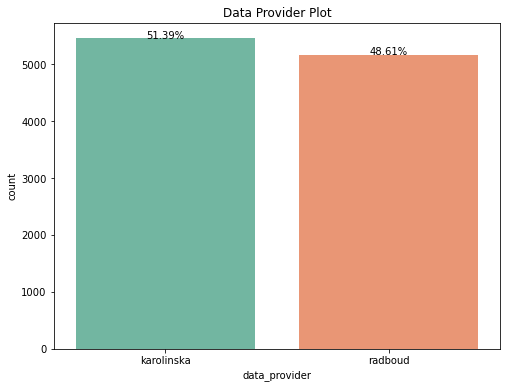

In [4]:
eda_helper_funcs.plot_count(df=train_df, feature='data_provider', title = 'Data Provider Plot')    

Samples are approximately evenly distributed in origin between the two research centers

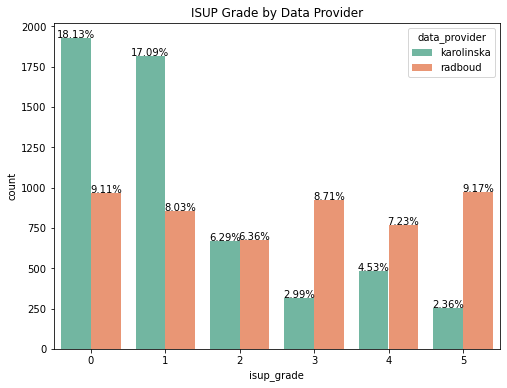

In [5]:
eda_helper_funcs.plot_relative_distribution(df=train_df, feature='isup_grade', hue='data_provider',
                           title = 'ISUP Grade by Data Provider', size=2)

Karolinska samples have approximately 2:1 representation vs. Radboud in no cancer (ISUP = 0) and low-risk cancer (ISUP = 1) groups, while Radboud is disproportionately represented in the high risk cancer samples from ISUP 3 and up. Further investigation will need to be done in order to determine if the distributions of samples are in fact different and need rebalancing for training or if this difference in distribution arises from the grading done by pathologists at the two centers.

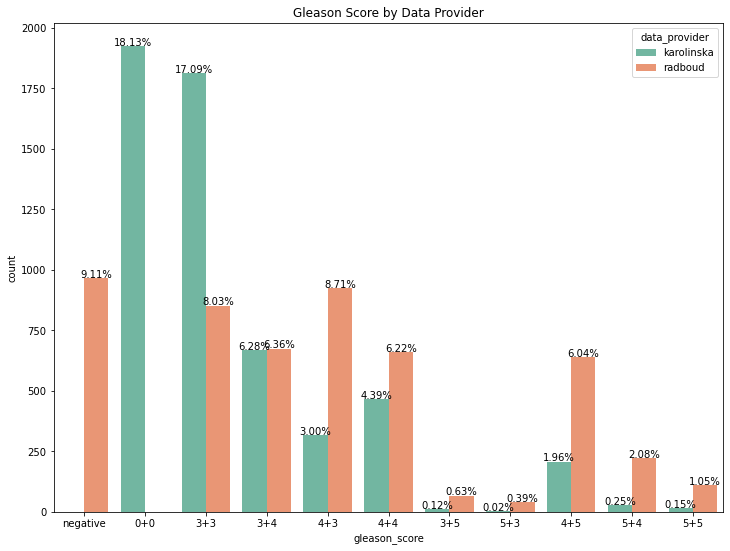

In [6]:
eda_helper_funcs.plot_relative_distribution(df=train_df, feature='gleason_score', hue='data_provider', 
                           title = 'Gleason Score by Data Provider', size=3, 
                           order = ['negative', '0+0','3+3','3+4','4+3','4+4','3+5','5+3','4+5','5+4','5+5' ])

The Gleason score distribution follows the ISUP grade distribution with added granularity.

## Viewing Sample Images

In [7]:
BASE_PATH = '../input/prostate-cancer-grade-assessment'
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

Test image file:  ../input/prostate-cancer-grade-assessment/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff

Full-size image dimensions: 		 (5888, 25344) 
One-fourth size image dimensions: 	 (1472, 6336) 
One-sixteenth size image dimensions: 	 (368, 1584) 

Image preview:


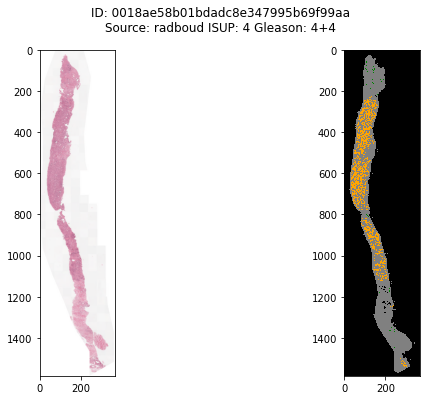

In [9]:
eda_helper_funcs.img_mask_check(train_df.index[2],data_dir,mask_dir,train_df)

Test image file:  ../input/prostate-cancer-grade-assessment/train_images/001c62abd11fa4b57bf7a6c603a11bb9.tiff

Full-size image dimensions: 		 (23904, 28664) 
One-fourth size image dimensions: 	 (5976, 7166) 
One-sixteenth size image dimensions: 	 (1494, 1791) 

Image preview:


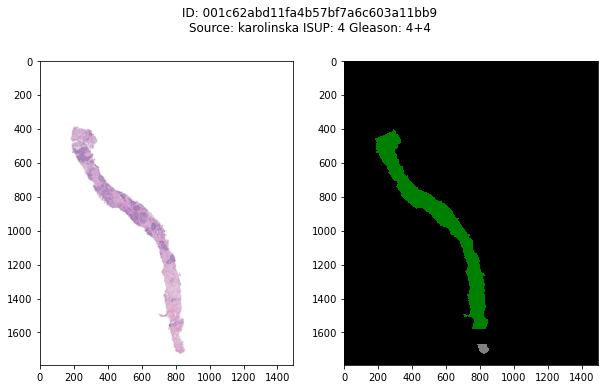

In [10]:
eda_helper_funcs.img_mask_check(train_df.index[3],data_dir,mask_dir,train_df)

From the two sets of images above we can see a few important aspects:
* The images are very large, even at 1/16th resolution the dimensions are over 1,000 pixels
* The labeling methods and resulting data from the two research centers are very different

Radboud - Used deep learning algorithms to label glands individually so their masks contain noise and inaccuracies but much higher granularity than Karolinska.
Karolinska - Slides are labeled by large regions rather than at the individual gland level, making it much harder to pinpoint specific features and regions of interest

The two centers also assigned very different labels.

Radboud masks:
* 0: background (non tissue) or unknown
* 1: stroma (connective tissue, non-epithelium tissue)
* 2: healthy (benign) epithelium
* 3: cancerous epithelium (Gleason 3)
* 4: cancerous epithelium (Gleason 4)
* 5: cancerous epithelium (Gleason 5)

Karolinska masks:
* 0: background (non tissue) or unknown 
* 1: benign tissue (stroma and epithelium combined)
* 2: cancerous tissue (stroma and epithelium combined)

## Zoomed Image Regions

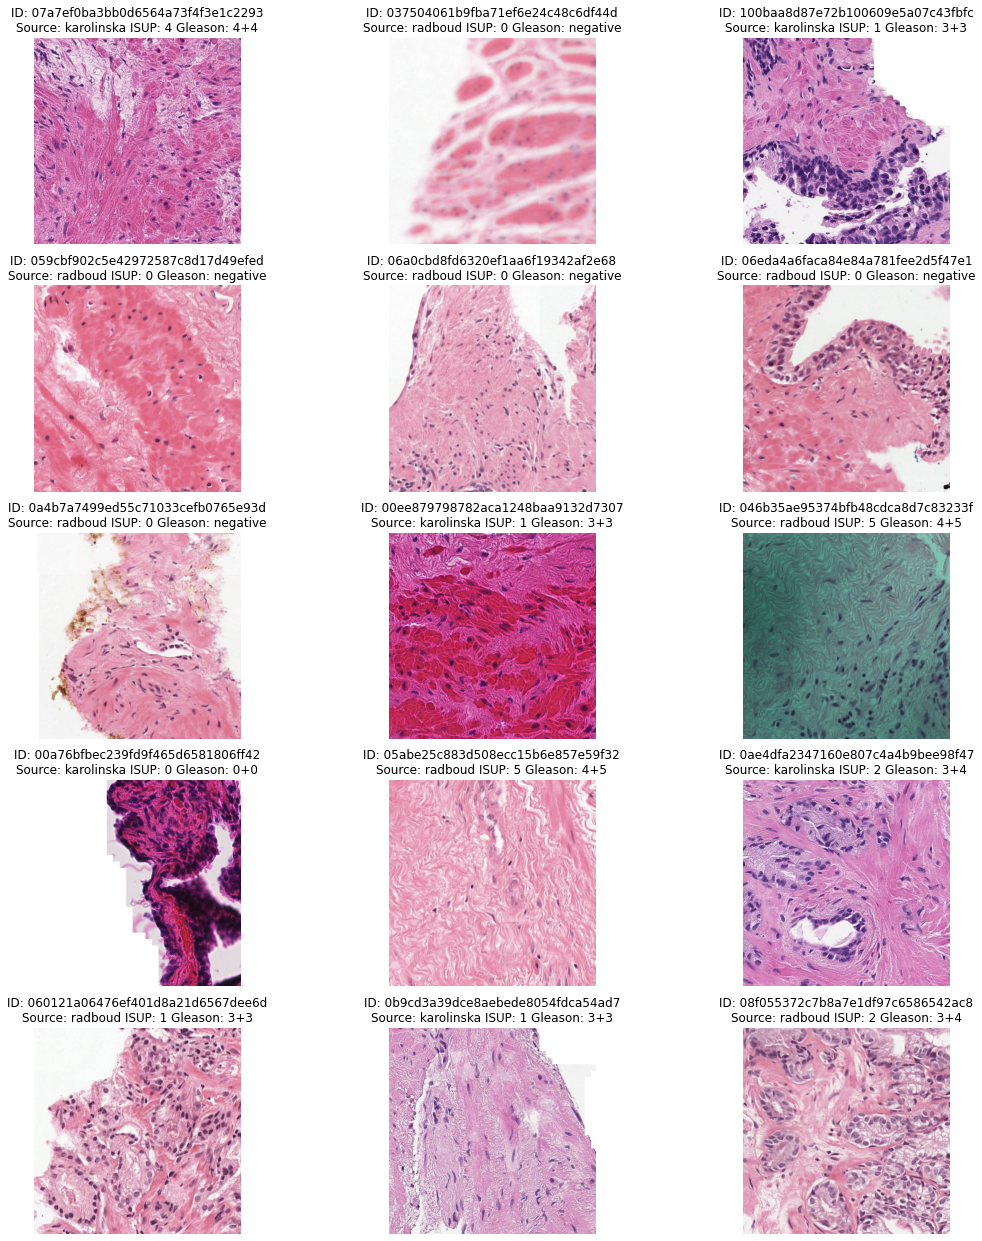

In [14]:
image_ids = ['07a7ef0ba3bb0d6564a73f4f3e1c2293',  '037504061b9fba71ef6e24c48c6df44d',  '100baa8d87e72b100609e5a07c43fbfc',
          '059cbf902c5e42972587c8d17d49efed',  '06a0cbd8fd6320ef1aa6f19342af2e68',  '06eda4a6faca84e84a781fee2d5f47e1',
          '0a4b7a7499ed55c71033cefb0765e93d',  '00ee879798782aca1248baa9132d7307',  '046b35ae95374bfb48cdca8d7c83233f',
          '00a76bfbec239fd9f465d6581806ff42',  '05abe25c883d508ecc15b6e857e59f32',  '0ae4dfa2347160e807c4a4b9bee98f47',
          '060121a06476ef401d8a21d6567dee6d',  '0b9cd3a39dce8aebede8054fdca54ad7',  '08f055372c7b8a7e1df97c6586542ac8',
          ]

eda_helper_funcs.display_many_images(image_ids,data_dir,train_df)

Above we can see that due to the specifics of their staining and imaging processes, the two centers have produced images of distinctly different colorations with many of the Karolinska images having more vibrant colors (to be quantified later). Also in the 3rd row, 3rd column there is an image that appears unusually greenish in color. This is due to the pen marks that can be found as artifacts on some of the slides from the Radboud pathologists during the annotation process.

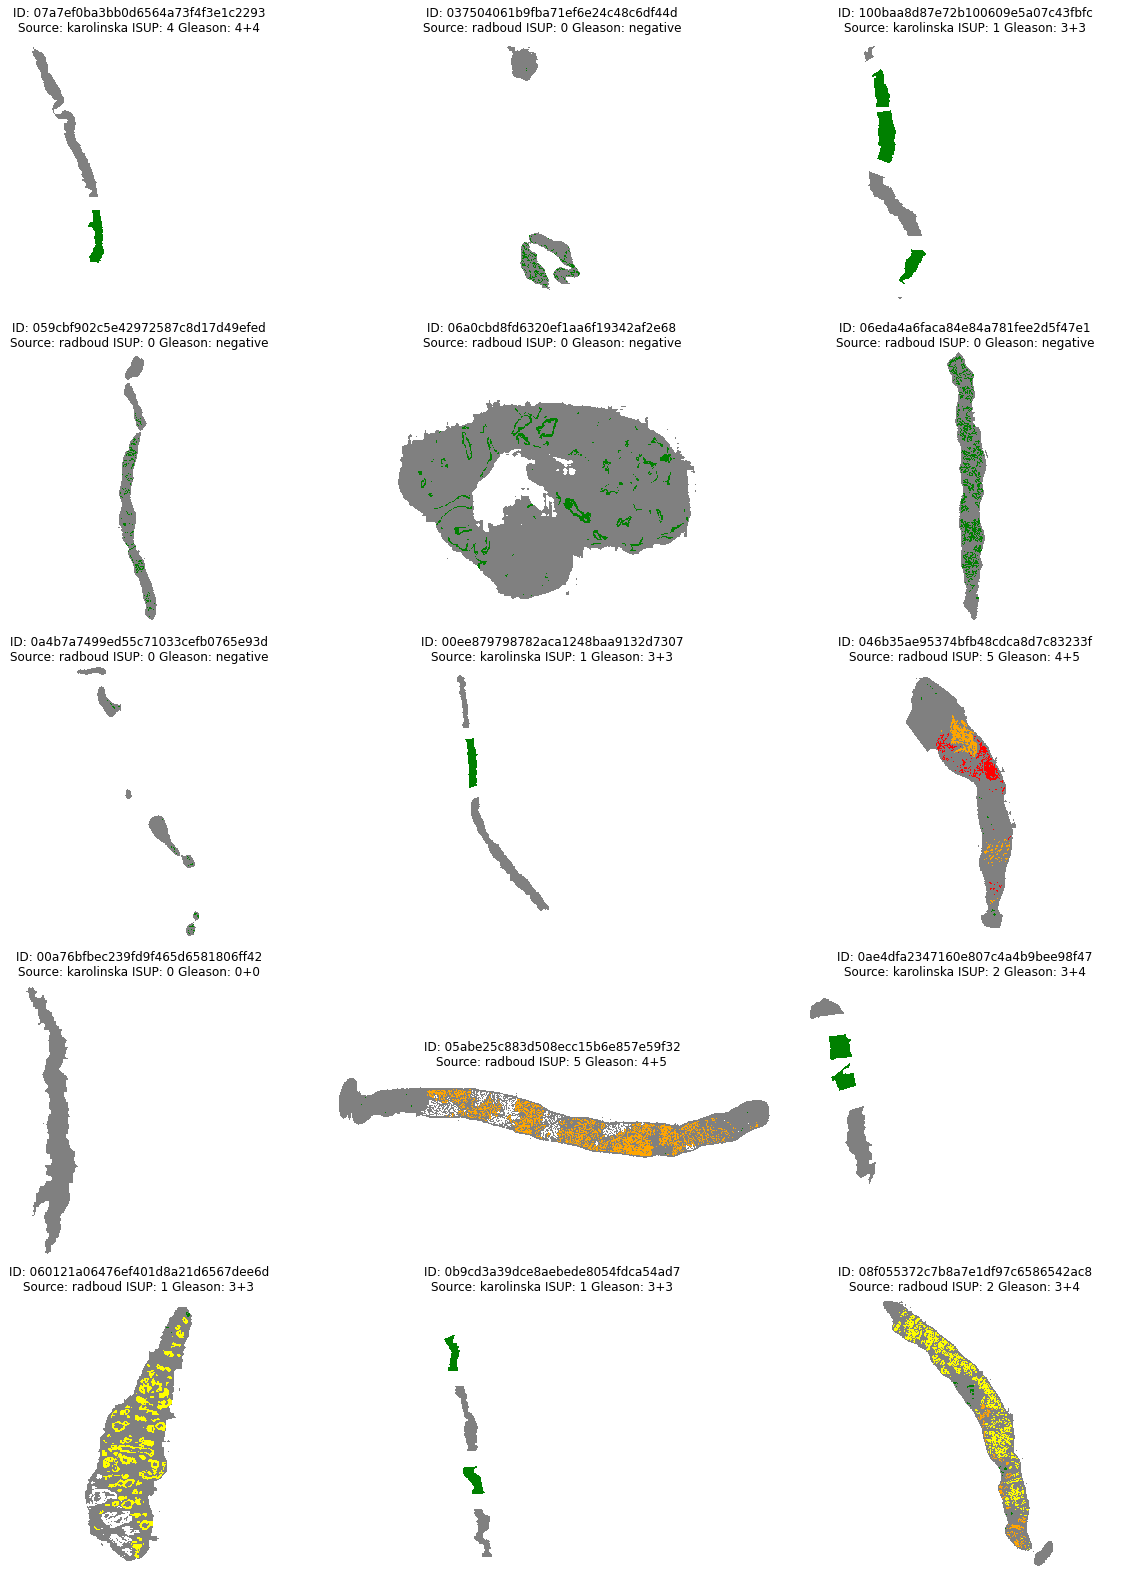

In [12]:
eda_helper_funcs.display_many_masks(image_ids,mask_dir,train_df)

Better views of a few of the pen-marked images below:

Test image file:  ../input/prostate-cancer-grade-assessment/train_images/fd6fe1a3985b17d067f2cb4d5bc1e6e1.tiff

Full-size image dimensions: 		 (7424, 25600) 
One-fourth size image dimensions: 	 (1856, 6400) 
One-sixteenth size image dimensions: 	 (464, 1600) 

Image preview:


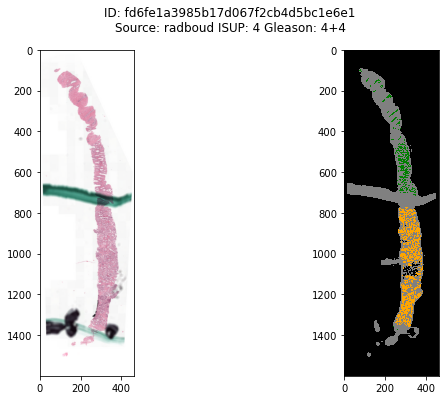

In [15]:
eda_helper_funcs.img_mask_check('fd6fe1a3985b17d067f2cb4d5bc1e6e1',data_dir,mask_dir,train_df)

Test image file:  ../input/prostate-cancer-grade-assessment/train_images/ebb6a080d72e09f6481721ef9f88c472.tiff

Full-size image dimensions: 		 (6400, 24064) 
One-fourth size image dimensions: 	 (1600, 6016) 
One-sixteenth size image dimensions: 	 (400, 1504) 

Image preview:


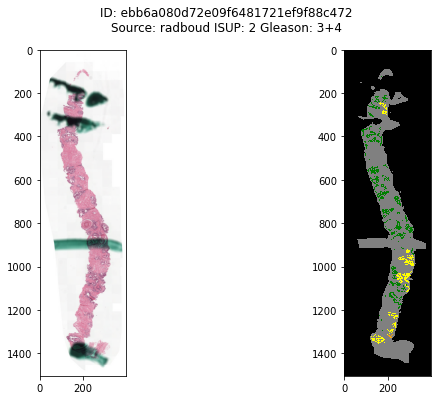

In [16]:
eda_helper_funcs.img_mask_check('ebb6a080d72e09f6481721ef9f88c472',data_dir,mask_dir,train_df)

Not only do the pen marks distort the images themselves, but they are also picked up by the Radboud center's labeling algorithm and result in incorrect labeling of regions of the accompanying masks